In [287]:
import pandas as pd

from df_information import DataFrameInfo
from data_transform import DataTransform
from df_transform import DataFrameTransform
from plotter import Plotter

### Loading variables 

In [288]:
# load the data into df
df = pd.read_csv('../loan_payments.csv')

In [289]:
# df_info contains methods that generate useful information about the DataFrame
df_info = DataFrameInfo()

# to do conversions on columns of data (e.g. changing its dtype, or date formats)
data_formatter = DataTransform()

# A df_transformer performs EDA transformations on the dataframe e.g. imputation
df_transformer = DataFrameTransform()

# A class to plot helpful visuals
plotter = Plotter()

Loaded DataFrameInfo()...
Loaded DataTransform()...
Loaded DataFrameTransform()...
Loaded Plotter()...


### Summary statistics 

Calling a few basic functions to get an overview of the dataframe. Calls like .head(), .info, .shape and .describe()

In [290]:
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.0,0.0,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.0,0.0,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.0,0.0,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.0,0.0,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.0,0.0,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL


In [291]:
df.shape

(54231, 43)

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

### Correct the column formats 

##### Dates

In [293]:
# Note how the ouptut format is 'Jan-2021'. we want it to be '2022-01-01'.
# The type of the column is also 'object', and not some kind of date.
df['issue_date'].head()

0    Jan-2021
1    Jan-2021
2    Jan-2021
3    Jan-2021
4    Jan-2021
Name: issue_date, dtype: object

In [294]:
# Columns which are currently objects, but need to be converted to dates 
object_to_date_columns = df[['issue_date', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date', 'earliest_credit_line']]

df = data_formatter.convert_obj_columns_to_date(df, column_list=object_to_date_columns, current_format="%b-%Y")

In [295]:
# The output confirms that the format has changed.
df['last_payment_date'].head()

0   2022-01-01
1   2022-01-01
2   2021-10-01
3   2021-06-01
4   2022-01-01
Name: last_payment_date, dtype: datetime64[ns]

##### Categories 

In [296]:
# Columns which are object types, but are to be converted to categorical types
obj_into_category_columns = df[['grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'application_type', 'payment_plan', 'term']]
obj_into_category_columns.head()

,grade,sub_grade,employment_length,home_ownership,verification_status,loan_status,purpose,application_type,payment_plan,term
0,A,A4,5 years,MORTGAGE,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
1,A,A3,9 years,RENT,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
2,A,A4,8 years,MORTGAGE,Source Verified,Fully Paid,credit_card,INDIVIDUAL,n,36 months
3,C,C4,1 year,RENT,Source Verified,Fully Paid,debt_consolidation,INDIVIDUAL,n,36 months
4,A,A1,10+ years,MORTGAGE,Verified,Current,debt_consolidation,INDIVIDUAL,n,36 months


Based on the above, it seems as though the grade column is redundant since the grade is always contained in the sub_grade. Let me test this first.

In [297]:
# Check if sub_grade's first letter matches grade
grade_matches = df['grade'] == df['sub_grade'].str[0]

# Check if all rows match 
if grade_matches.all():
  print('sub_grade always contains the grade')
else:
  print('sub_grade does not always contain the grade')

sub_grade always contains the grade


It is true, so I will go ahead and remove grade from the dataframe. 

In [298]:
df = df_transformer.drop_column(df, df['grade'])

In [299]:
obj_into_category_columns = df[['sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'application_type', 'payment_plan', 'term']]
obj_into_category_columns.head()

,sub_grade,employment_length,home_ownership,verification_status,loan_status,purpose,application_type,payment_plan,term
0,A4,5 years,MORTGAGE,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
1,A3,9 years,RENT,Not Verified,Current,credit_card,INDIVIDUAL,n,36 months
2,A4,8 years,MORTGAGE,Source Verified,Fully Paid,credit_card,INDIVIDUAL,n,36 months
3,C4,1 year,RENT,Source Verified,Fully Paid,debt_consolidation,INDIVIDUAL,n,36 months
4,A1,10+ years,MORTGAGE,Verified,Current,debt_consolidation,INDIVIDUAL,n,36 months


In [300]:
obj_into_category_columns = data_formatter.convert_object_columns_into_categories(obj_into_category_columns)

There are some numeric columns, where the vast majority of values are a single value, and the rest are spread out in low numbers. 

Such columns cannot be normally distributed easily, and so I will convert them into categorical columns with ranges to group thier values. 

There are some columns which I am unsure about converting to categories, so I will leave them as they are for now. They are also hard to distribute symetrically, but I am not confident that they actually should be. For future reference, they are:
- annual_inc
- last_payment_amount
- open_accounts
- out_prncp_inv
- out_prncp

In [301]:
df['collection_recovery_fee'].head()


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: collection_recovery_fee, dtype: float64

In [302]:

df['collection_recovery_fee'].value_counts()

collection_recovery_fee
0.0000      50788
1.4400          7
1.6900          6
1.7300          6
2.0800          6
            ...  
506.8728        1
75.6270         1
2.7103          1
2.1780          1
0.2300          1
Name: count, Length: 2944, dtype: int64

The value_counts() show that the majority of values are zero. Trying to normalise this distribution would change the underlying data too much, and so making it a categorical feature with ranges of values instead of numbers seems preferable. 

In [303]:
df['collections_12_mths_ex_med'].value_counts()

collections_12_mths_ex_med
0.0    53971
1.0      193
2.0       14
3.0        1
4.0        1
Name: count, dtype: int64

In [304]:
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].astype('category')

The Series above only contains 5 values and so it is easy to convert to a category. 

The next 5 columns (`delinq_2yrs`, `inq_last_6mths`, `recoveries`, `total_rec_late_fee`, ``collection_recovery_fee``) contain many more, and so I will create ranges from the spread of values and use those as categories. 

The last of those 3 are float64 colunms, and are to be converted to Int64's. There is no useful information lost from this conversion, and it simplifies the categorisation. 

In [305]:
df['delinq_2yrs'] = data_formatter.int64_to_category_with_ranges(df, df['delinq_2yrs'])
df['inq_last_6mths'] = data_formatter.int64_to_category_with_ranges(df, df['inq_last_6mths'])

In [306]:
df['recoveries'] = round(df['recoveries']).astype('Int64')
df['recoveries'] = data_formatter.int64_to_category_with_ranges(df, df['recoveries'])

df['total_rec_late_fee'] = round(df['total_rec_late_fee']).astype('Int64')
df['total_rec_late_fee'] = data_formatter.int64_to_category_with_ranges(df, df['total_rec_late_fee'])

df['collection_recovery_fee'] = round(df['collection_recovery_fee']).astype('Int64')
df['collection_recovery_fee'] = data_formatter.int64_to_category_with_ranges(df, df['collection_recovery_fee'])

In [307]:
df.head()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,sub_grade,employment_length,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A4,5 years,...,0,0,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A3,9 years,...,0,0,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A4,8 years,...,0,0,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C4,1 year,...,0,0,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A1,10+ years,...,0,0,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL


#### Numeric

In [308]:
# These four columns all represent a number of months, and so can be cast to int64s
float64_columns_into_int64 = df[['mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record']]
float64_columns_into_int64 = data_formatter.convert_float64_columns_into_int64s(float64_columns_into_int64)

### Handle null values

I will first identify the variables with missing values and determine the percentage of missing values in each variable.

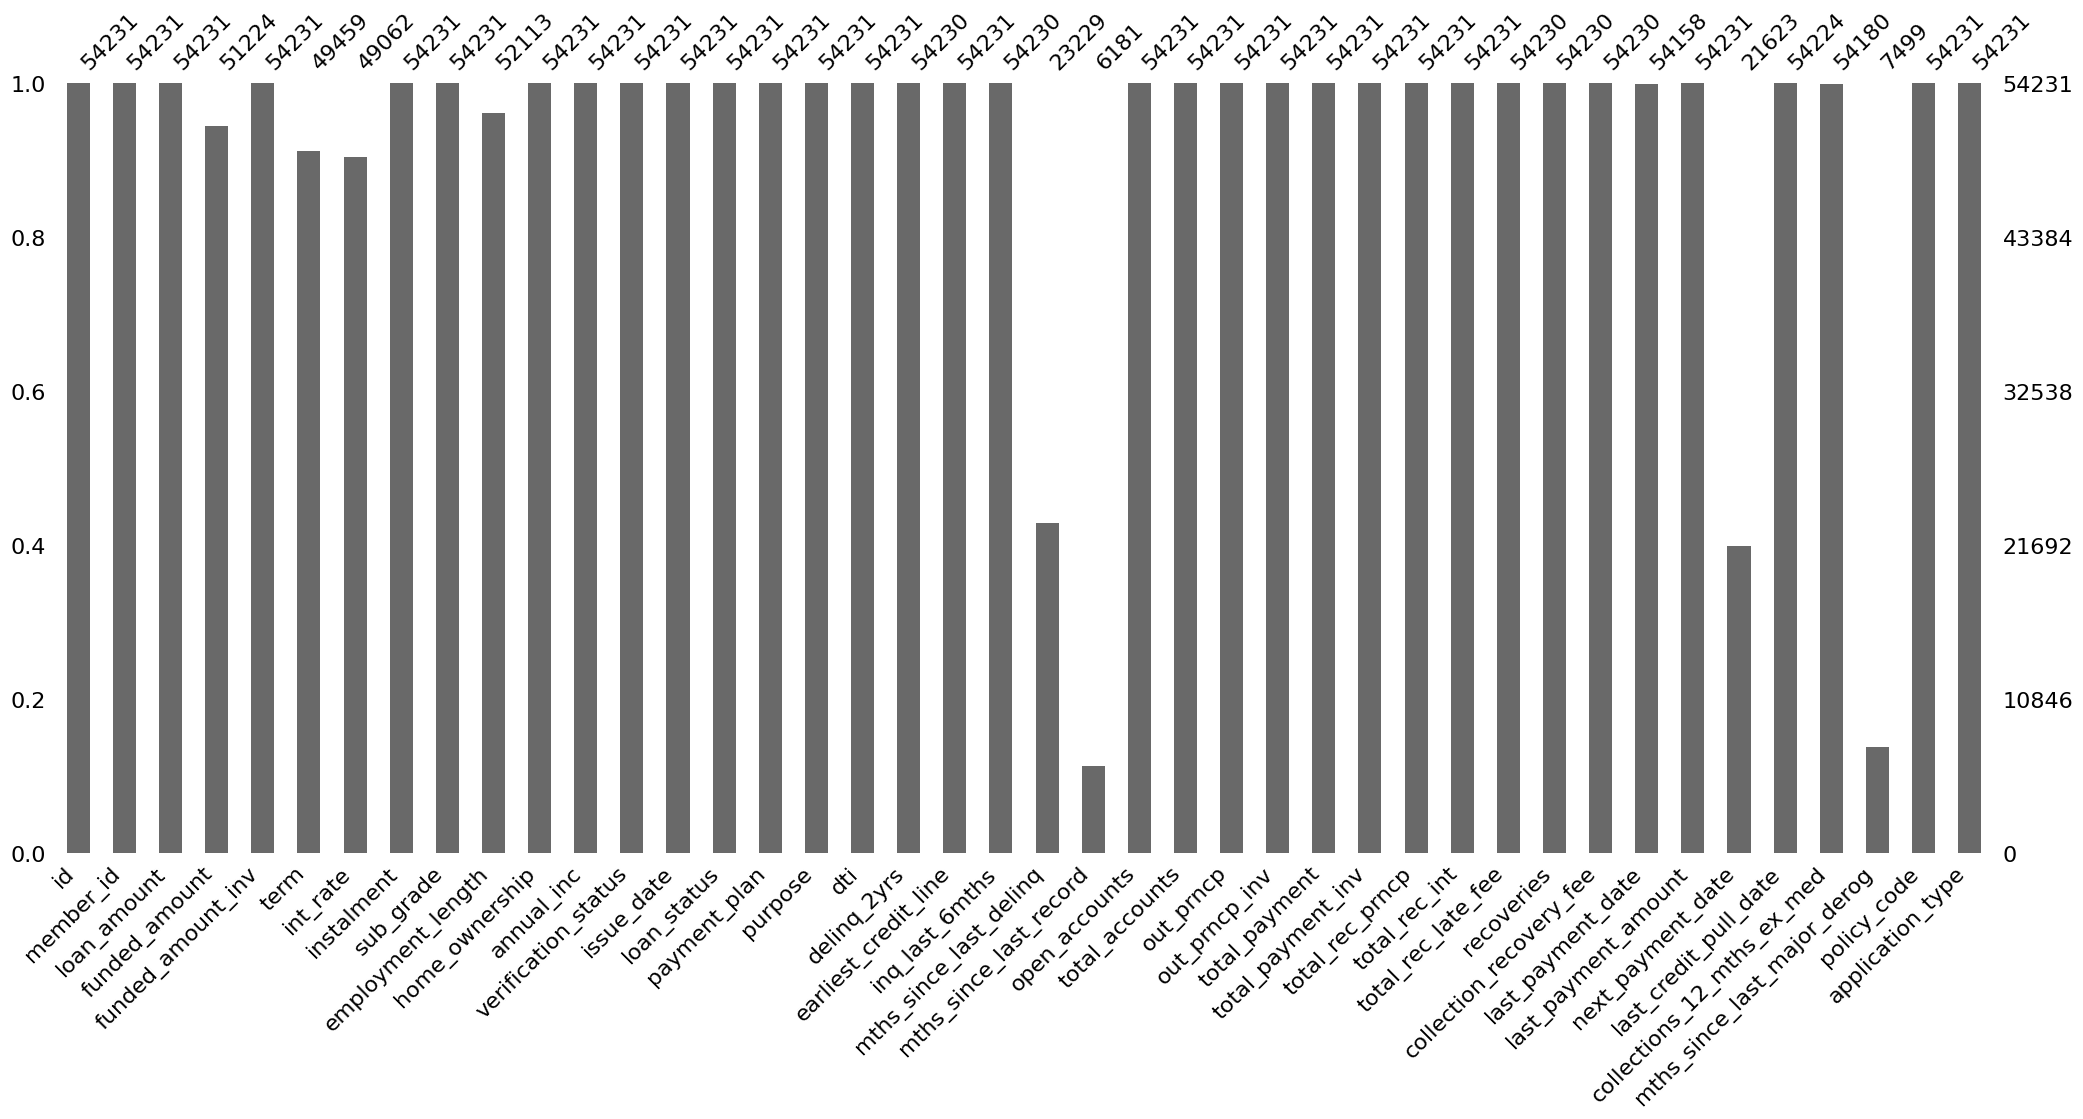

In [309]:
plot = plotter.show_null_bar_chart(df)

In [310]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 16 columns with null values left:



,% of nulls,# of nulls,dtype
mths_since_last_record,88.60,48050,float64
mths_since_last_major_derog,86.17,46732,float64
next_payment_date,60.13,32608,datetime64[ns]
mths_since_last_delinq,57.17,31002,float64
int_rate,9.53,5169,float64
term,8.80,4772,object
funded_amount,5.54,3007,float64
employment_length,3.91,2118,object
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category


#### Dropping columns

**I now will decide which of the above columns are worth dropping entirely, and proceed to do so.**

Based on the above there are 4 columns with very high proportions of nulls:

`[88.60%, 86.17%, 60.13%, 57.17%]`

The next biggest is 9.53%, which is a huge distance from the top 4.

As a result I am going to *remove all columns with >50% null values*.

In [311]:
df.shape

(54231, 42)

In [312]:
# returns a series showing the % of null values for every column in the dataframe
percent_of_nulls = df_info.percentage_of_nulls_in_data_frame(df)

# Extract columns whose majority (> 50%) of values are null, to pass into drop()
more_than_half_null_cols = percent_of_nulls[percent_of_nulls > 50.00]

# Drop the selected columns from the dataframe
df = df_transformer.drop_columns(df, more_than_half_null_cols)

In [313]:
df.shape

(54231, 38)

Printing shape before and after has confirmed that 4 columns have been removed, as it went from 42 down to 38. 

This is not to do with null handling, but I noticed that the policy_code column has a value of 1 for every single entry, so the column itself is not of any use to our analysis. 

Since we have a lot of other columns to attend to, I will drop the policy_code column to remove it from the data going forward. 

In [314]:
df = df_transformer.drop_column(df, df['policy_code'])

#### Imputing

In [315]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 12 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
term,8.80,4772,object
funded_amount,5.54,3007,float64
employment_length,3.91,2118,object
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category


##### Mode imputations

The column `(term)` only has two values. 

- 36.0 occurs 35845 times
- 60.0 occurs 13614 times

There could be a relationship between this value and the other variables worth exploring, but for now I will impute the missing values with the mode. 

In [316]:
df['term'] = df_transformer.impute_nulls_in_column(df['term'], 'mode')

The column `employment_length` is categorical and so mode is the most appropriate replacement. 

Since ~ 4% of its values are null, doing this may skew the data. I can address this later.

In [317]:
df['employment_length'] = df_transformer.impute_nulls_in_column(df['employment_length'], 'mode')

In [318]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 10 columns with null values left:



,% of nulls,# of nulls,dtype
int_rate,9.53,5169,float64
funded_amount,5.54,3007,float64
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


##### Median imputations

For this stage I am simply going to use the average to impute `int_rate` and `funded_amount`.

In [319]:
df['int_rate'] = df_transformer.impute_nulls_in_column(df['int_rate'], 'median')

In [320]:
df['funded_amount'] = df_transformer.impute_nulls_in_column(df['funded_amount'], 'median')

In [321]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 8 columns with null values left:



,% of nulls,# of nulls,dtype
last_payment_date,0.13,73,datetime64[ns]
collections_12_mths_ex_med,0.09,51,category
last_credit_pull_date,0.01,7,datetime64[ns]
delinq_2yrs,0.00,1,category
inq_last_6mths,0.00,1,category
total_rec_late_fee,0.00,1,category
recoveries,0.00,1,category
collection_recovery_fee,0.00,1,category


#### Dropping rows 

We have three rows left:

- The `last_credit_pull_date` column has `7` null values, or `~0.01%` of them.
- The `collections_12_mths_ex_med` column has `51` null values, or `~0.09%` of them.
- The `last_payment_date` column has `73` null values, or `~0.13%` of them

I am going to delete all of the corresponding rows. 

In [322]:
df = df_transformer.drop_rows_of_null_column_entries(df, df['last_credit_pull_date'])
df = df_transformer.drop_rows_of_null_column_entries(df, df['collections_12_mths_ex_med'])
df = df_transformer.drop_rows_of_null_column_entries(df, df['last_payment_date'])

#### Confirm all nulls removed 

In [323]:
message, progress = df_info.print_null_removal_progress(df)
print(message)
progress

There are 5 columns with null values left:



,% of nulls,# of nulls,dtype
delinq_2yrs,0.0,1,category
inq_last_6mths,0.0,1,category
total_rec_late_fee,0.0,1,category
recoveries,0.0,1,category
collection_recovery_fee,0.0,1,category


<Axes: >

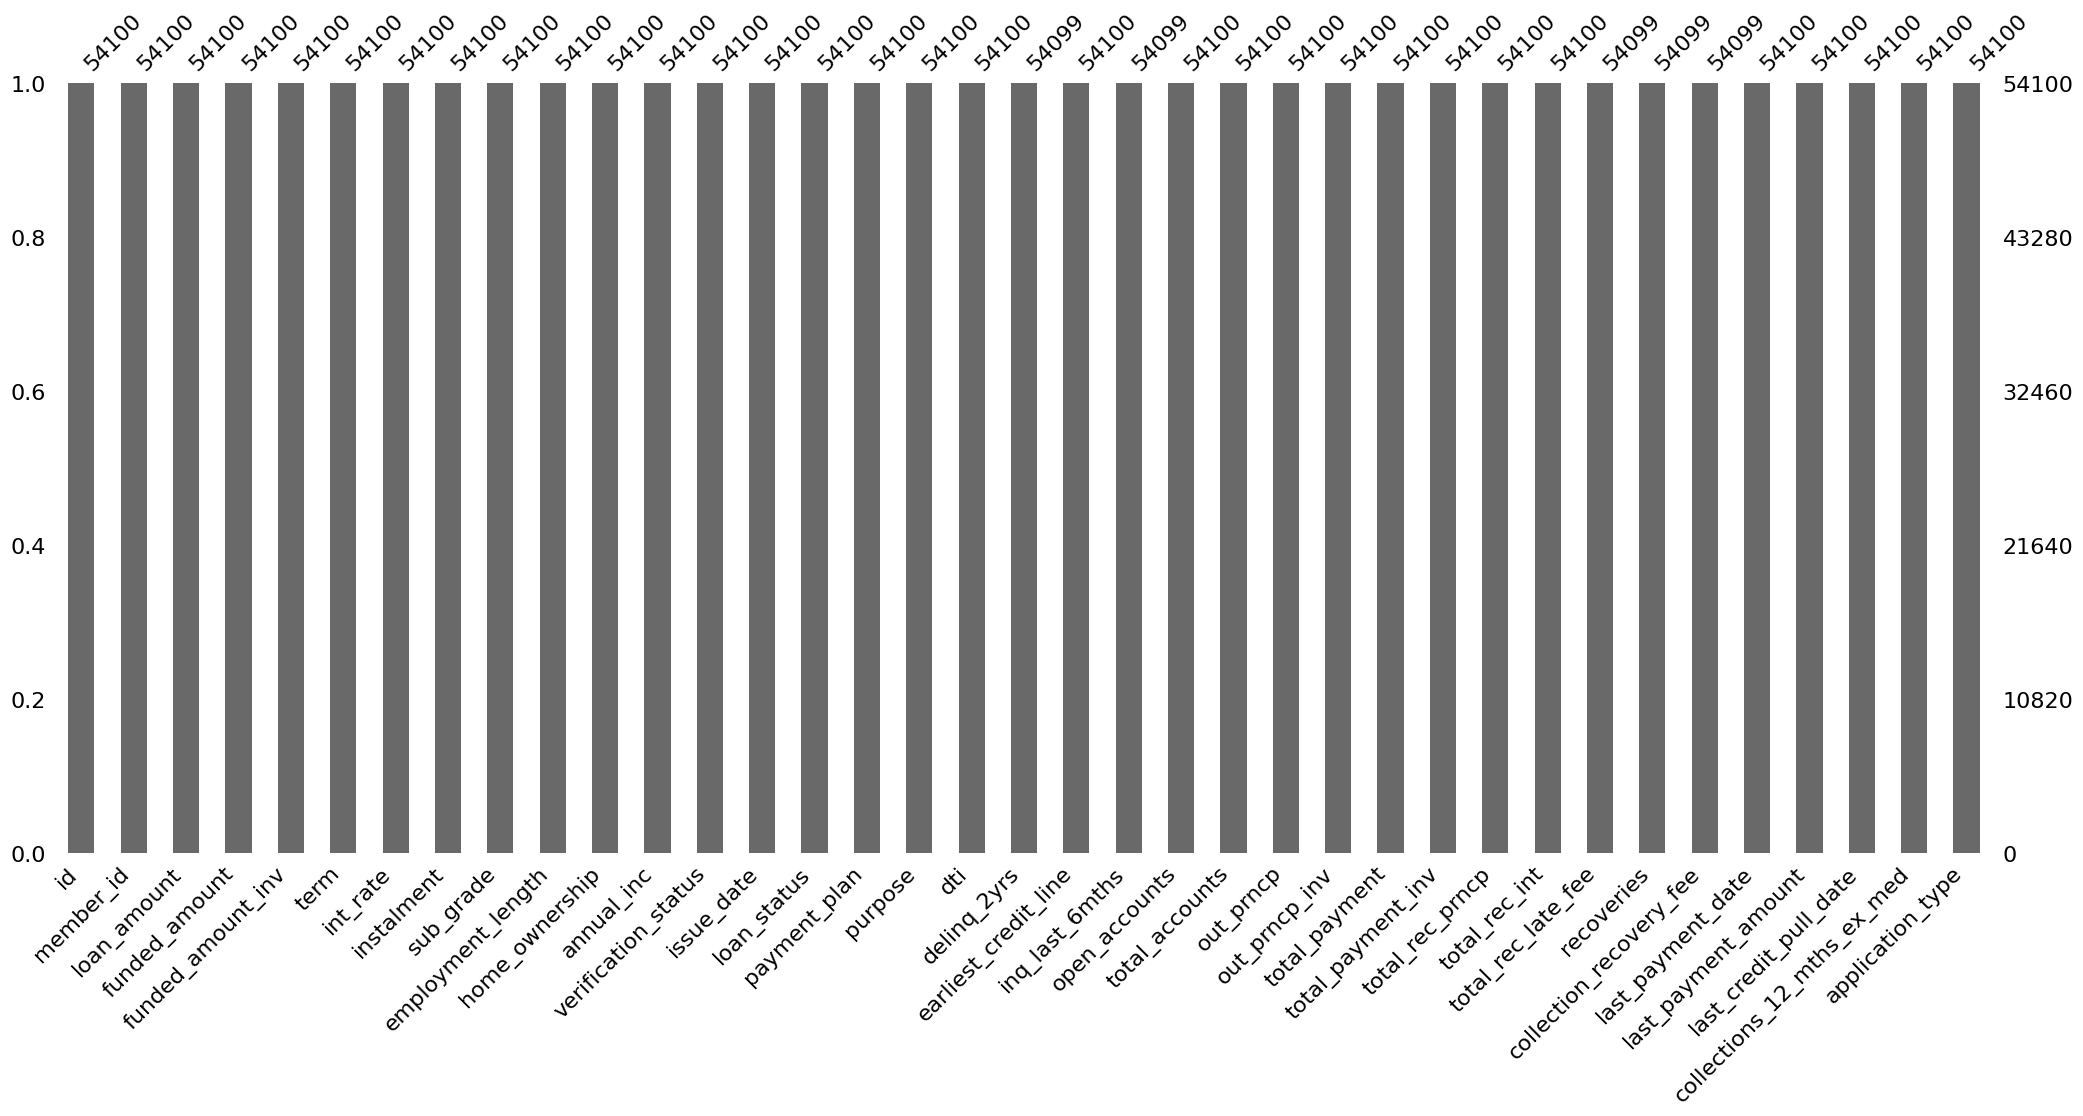

In [324]:
plotter.show_null_bar_chart(df)

### Skewed data

Lets first look at the skew value for each of the columns

In [325]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df, sort=True)

# drop the two id columns since they are not to be changed anyway so skew is irrelevent
skew_series = skew_series.drop(['id', 'member_id'])

# construct a dataframe with these columns
skew_df = df[list(skew_series.index)]

skew_df

,annual_inc,last_payment_amount,out_prncp_inv,out_prncp,total_rec_int,total_payment,total_rec_prncp,total_payment_inv,open_accounts,instalment,funded_amount,funded_amount_inv,loan_amount,total_accounts,int_rate,dti
0,46000.0,248.82,5529.70,5529.70,512.21,2982.51,2470.30,2982.51,12,248.82,8000.0,8000.00,8000,27,7.49,19.54
1,50000.0,407.52,9102.83,9102.83,787.94,4885.11,4097.17,4885.11,15,407.52,13200.0,13200.00,13200,31,6.99,24.20
2,73913.0,12850.16,0.00,0.00,824.54,16824.54,16000.00,16824.54,7,497.63,16000.0,16000.00,16000,18,7.49,16.92
3,42000.0,13899.67,0.00,0.00,947.47,15947.47,15000.00,15947.47,6,514.93,15000.0,15000.00,15000,13,14.31,35.52
4,145000.0,456.54,10297.47,10297.47,770.93,5473.46,4702.53,5473.46,23,456.54,15000.0,15000.00,15000,50,6.03,3.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,30000.0,538.97,0.00,0.00,207.77,1207.76,999.99,0.00,9,35.20,1000.0,0.00,1000,15,16.08,23.84
54203,18000.0,193.55,0.00,0.00,933.06,6933.05,5999.99,544.67,4,192.60,6000.0,502.69,6000,4,9.64,2.87
54204,61800.0,126.29,0.00,0.00,495.79,4495.79,4000.00,1742.14,12,124.89,4000.0,1550.00,4000,16,7.75,3.46
54221,21000.0,85.66,0.00,0.00,303.77,5803.77,5500.00,5751.01,5,185.74,5500.0,5450.00,5500,6,13.16,19.20


In [326]:
skew_series

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
total_rec_int          2.203625
total_payment          1.269266
total_rec_prncp        1.262007
total_payment_inv      1.258474
open_accounts          1.059493
instalment             0.996150
funded_amount          0.869102
funded_amount_inv      0.814251
loan_amount            0.804312
total_accounts         0.780083
int_rate               0.456055
dti                    0.189020
dtype: float64

In order to decide a cut off point for considering a column as skewed, I will look into those which appear to be normally distributed. 

The table above shows the skewness of the numeric features, sorted with the highest first. 

The closer a skew value is to 0, the more normally distributed it is; those lower in the table have the least skew.

To determine a cuttoff point for skewness *I will look at the kde histplot for each of the **last 4** values in the table*, focusing on how the rise in the skew value affects the extend of the skew. 

In [327]:
last_4_skew_cols = skew_series.tail(4)
last_four_names = [str(col_name) for col_name in last_4_skew_cols.index]
last_4_df = df[last_four_names]

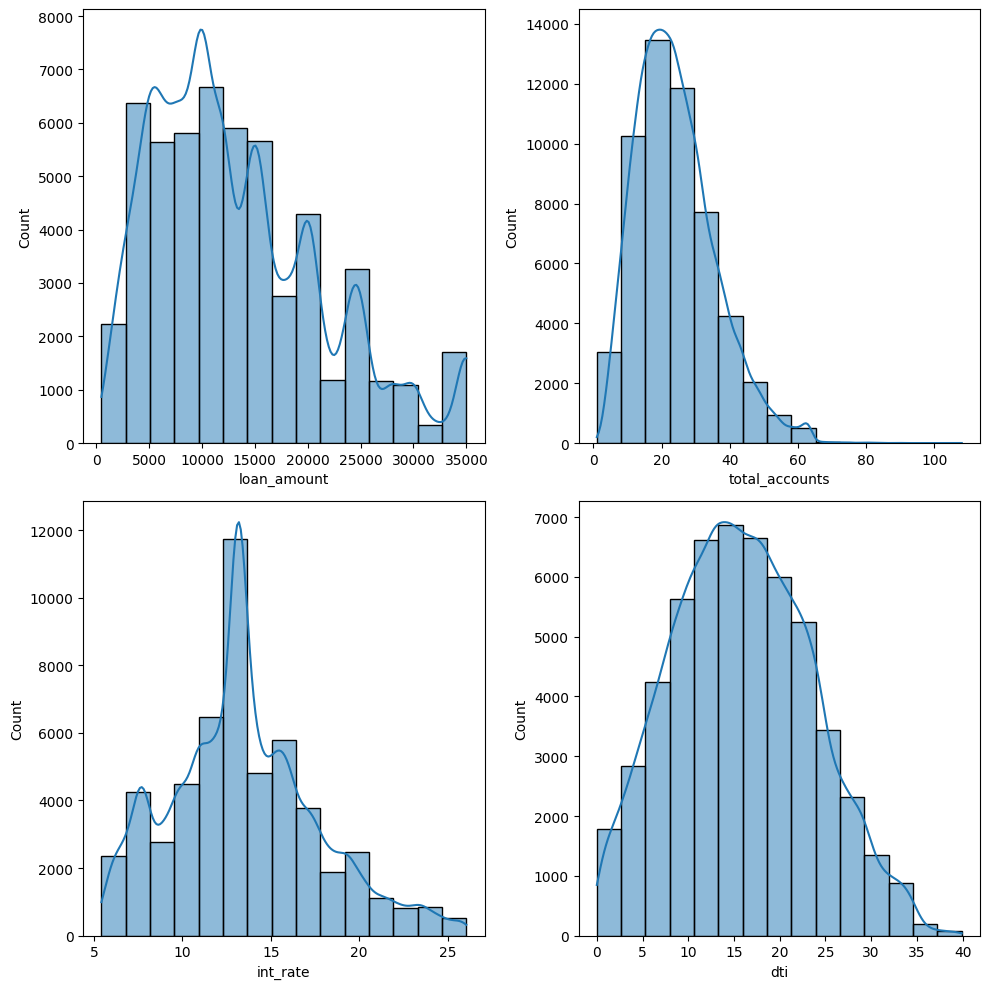

In [328]:
plotter.plot_histogram_quad(last_4_df)

Looking at the above I notice that the lowest skew values at which skewness becomes apparent is 0.78 for the total_accounts column.

The next lowest is int_rate with a value of 0.456, and that looks normally distributed enough. 

As a result I am going to set my skew_threshold at 0.5.

#### Transform skewed columns 

Let's see the columns and their skews after applying the skew threshold.

In [329]:
SKEW_THRESHOLD = 0.5

# This will remove int_rate and dti since they are symmetric enough already.
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
total_rec_int          2.203625
total_payment          1.269266
total_rec_prncp        1.262007
total_payment_inv      1.258474
open_accounts          1.059493
instalment             0.996150
funded_amount          0.869102
funded_amount_inv      0.814251
loan_amount            0.804312
total_accounts         0.780083
dtype: float64

In [330]:
# construct a dataframe with these columns
skew_df = df[list(skew_series.index)]

skew_df

,annual_inc,last_payment_amount,out_prncp_inv,out_prncp,total_rec_int,total_payment,total_rec_prncp,total_payment_inv,open_accounts,instalment,funded_amount,funded_amount_inv,loan_amount,total_accounts
0,46000.0,248.82,5529.70,5529.70,512.21,2982.51,2470.30,2982.51,12,248.82,8000.0,8000.00,8000,27
1,50000.0,407.52,9102.83,9102.83,787.94,4885.11,4097.17,4885.11,15,407.52,13200.0,13200.00,13200,31
2,73913.0,12850.16,0.00,0.00,824.54,16824.54,16000.00,16824.54,7,497.63,16000.0,16000.00,16000,18
3,42000.0,13899.67,0.00,0.00,947.47,15947.47,15000.00,15947.47,6,514.93,15000.0,15000.00,15000,13
4,145000.0,456.54,10297.47,10297.47,770.93,5473.46,4702.53,5473.46,23,456.54,15000.0,15000.00,15000,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,30000.0,538.97,0.00,0.00,207.77,1207.76,999.99,0.00,9,35.20,1000.0,0.00,1000,15
54203,18000.0,193.55,0.00,0.00,933.06,6933.05,5999.99,544.67,4,192.60,6000.0,502.69,6000,4
54204,61800.0,126.29,0.00,0.00,495.79,4495.79,4000.00,1742.14,12,124.89,4000.0,1550.00,4000,16
54221,21000.0,85.66,0.00,0.00,303.77,5803.77,5500.00,5751.01,5,185.74,5500.0,5450.00,5500,6


First I am going to transform the column with the least skew:

`total_accounts` has a skew of `0.779`

In [331]:
# get the Series for the column with the lowest skew
skew_col_names = list(skew_series.index)
least_skewed_col_name: str = skew_col_names[len(skew_col_names) - 1]
least_skewed_col = df[least_skewed_col_name]

In [332]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df, sort=True)
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series = skew_series.drop(['id', 'member_id'])
skew_series

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
total_rec_int          2.203625
total_payment          1.269266
total_rec_prncp        1.262007
total_payment_inv      1.258474
open_accounts          1.059493
instalment             0.996150
funded_amount          0.869102
funded_amount_inv      0.814251
loan_amount            0.804312
total_accounts         0.780083
dtype: float64

Colum: total_accounts, with skew of 0.78.
Colum: total_accounts, with skew of -0.013.


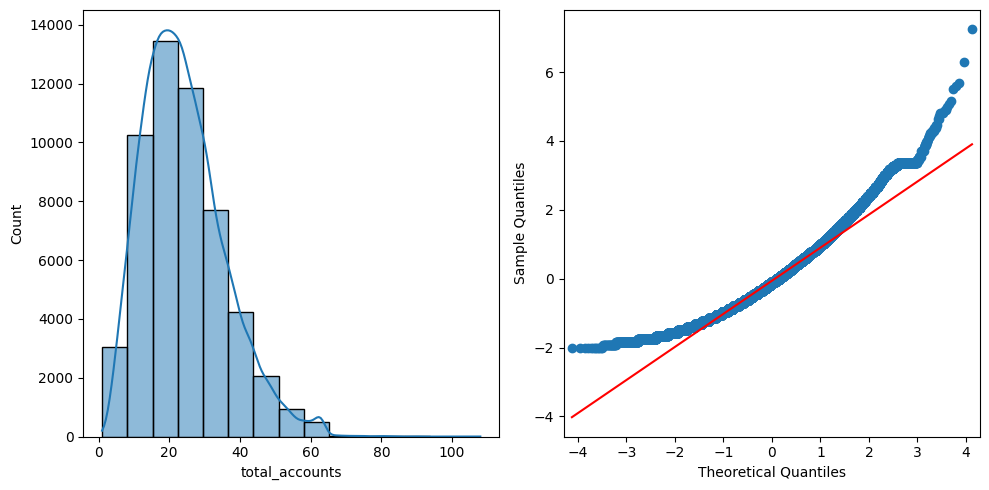

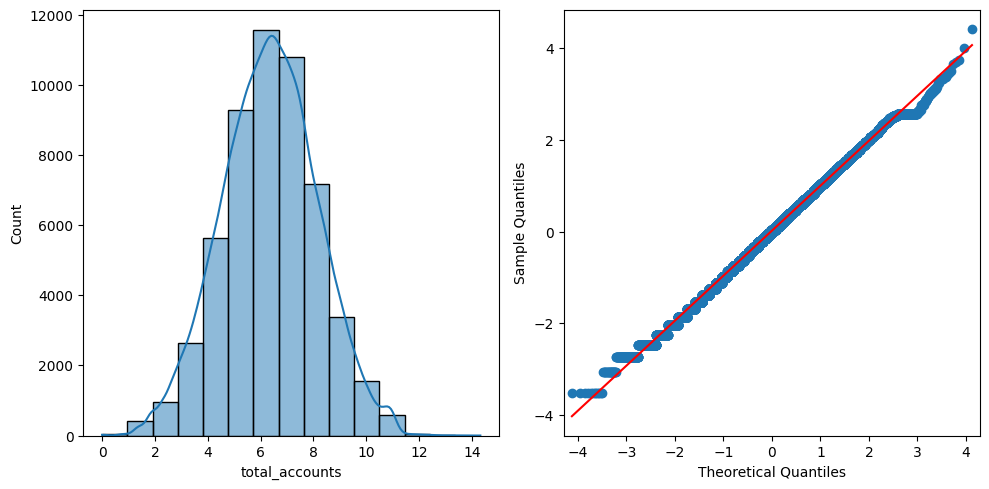

In [333]:
column_name = "total_accounts"
column = df[column_name]
msg = plotter.plot_histogram_and_qq(column)
print(msg)

# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)

df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

column = df[column_name]
msg = plotter.plot_histogram_and_qq(column)
print(msg)

In [334]:
column = df["loan_amount"]
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

column = df["funded_amount"]
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

column = df["instalment"]
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

column = df["total_payment"]
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

column = df["total_rec_int"]
# Apply box cox transform 
transformed_column = df_transformer.box_cox_transform(column)
df = df_transformer.replace_column_after_box_cox(df, column, transformed_column)

In [335]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df, sort=True)
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series = skew_series.drop(['id', 'member_id'])
skew_series

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
total_rec_prncp        1.262007
total_payment_inv      1.258474
open_accounts          1.059493
funded_amount_inv      0.814251
dtype: float64

The following are successfully updated with a box-cox transform.

- total_accounts
- loan_amount
- funded_amount
- instalment
- total_payment
- total_rec_int

And the following are not, due to containing values equal to 0
           
- total_rec_prncp      
- total_payment_inv    
- funded_amount_inv


In [336]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df, sort=True)
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series = skew_series.drop(['id', 'member_id'])
skew_series

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
total_rec_prncp        1.262007
total_payment_inv      1.258474
open_accounts          1.059493
funded_amount_inv      0.814251
dtype: float64

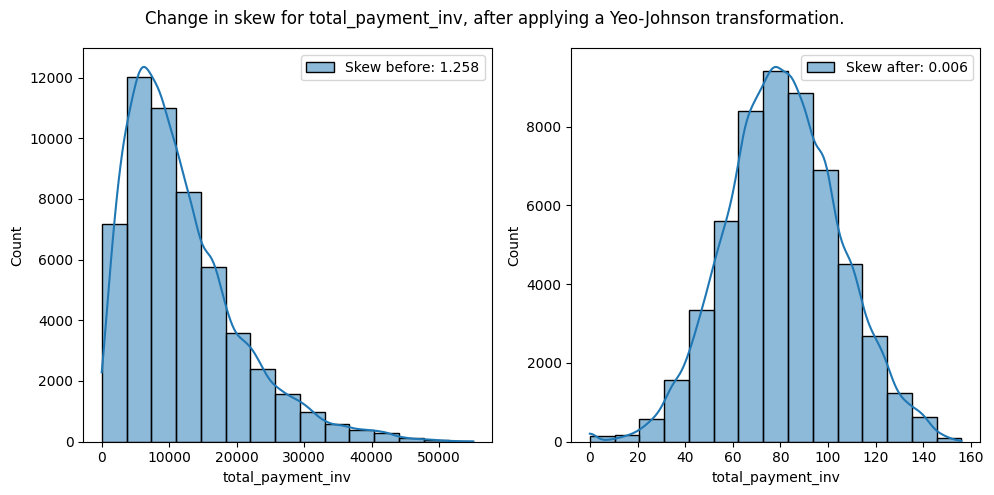

In [337]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['total_payment_inv']
column_after = df["total_payment_inv"] = df_transformer.yeo_johnson_transform(df['total_payment_inv'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

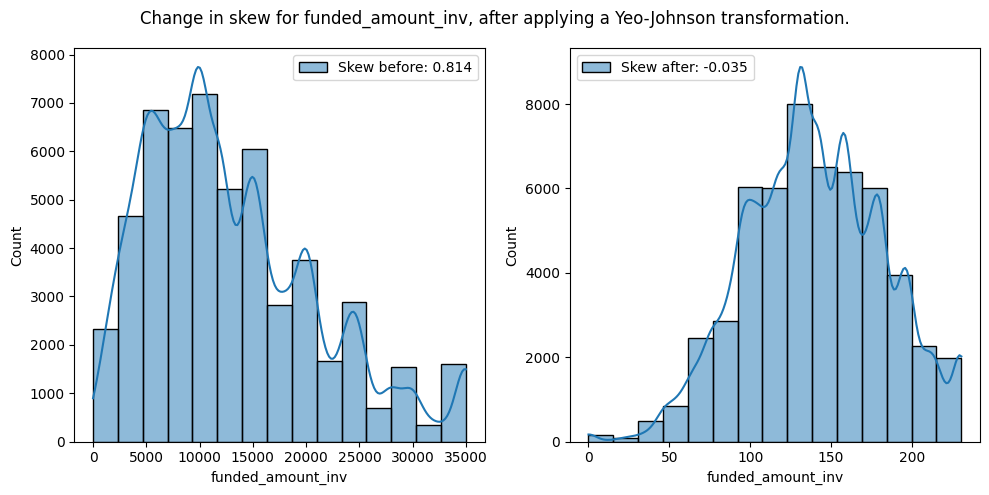

In [338]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['funded_amount_inv']
column_after = df["funded_amount_inv"] = df_transformer.yeo_johnson_transform(df['funded_amount_inv'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

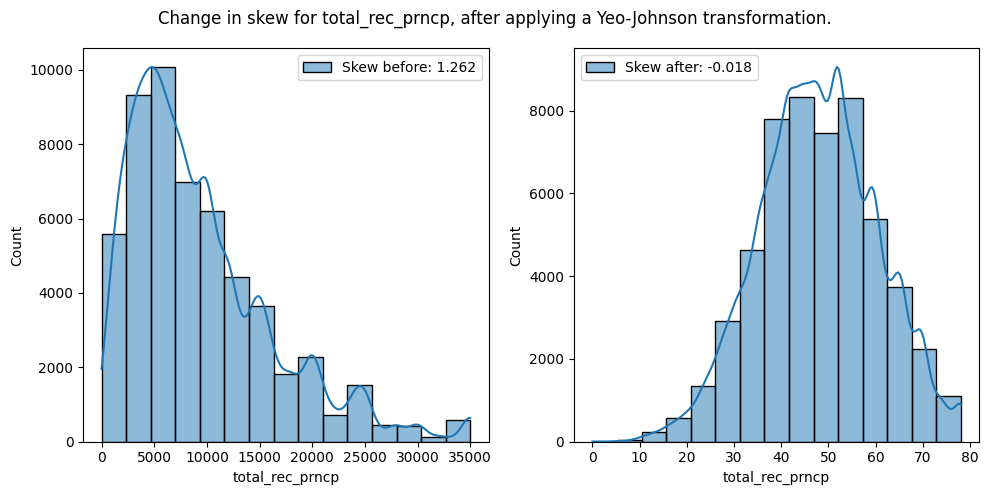

In [339]:
# Apply a Yeo-Johnson transform, and visualise the skewness before and after 
column_before = df['total_rec_prncp']
column_after = df["total_rec_prncp"] = df_transformer.yeo_johnson_transform(df['total_rec_prncp'])

plotter.plot_histogram_before_and_after_transform(column_before, column_after, transform_name="Yeo-Johnson")

In [340]:
# get a series showing the skew value for each column
skew_series = df_info.measure_skew_for_all_columns(df, sort=True)
skew_series = skew_series[skew_series > SKEW_THRESHOLD]
skew_series = skew_series.drop(['id', 'member_id'])
skew_series
# outliers = df_info.get_outliers_from_z_score(df['total_rec_prncp'])
# plotter.scatter_outliers(original=df['total_rec_prncp'], outliers=outliers)

annual_inc             8.735737
last_payment_amount    2.496079
out_prncp_inv          2.352946
out_prncp              2.352526
open_accounts          1.059493
dtype: float64

In [341]:
df['annual_inc'] = df_transformer.log_transform(df['annual_inc'])
df['annual_inc'].skew()

0.14181830888070776

### Dropping overly-correlated columns

Print the correlation heatmap for the numeric columns of the data frame 

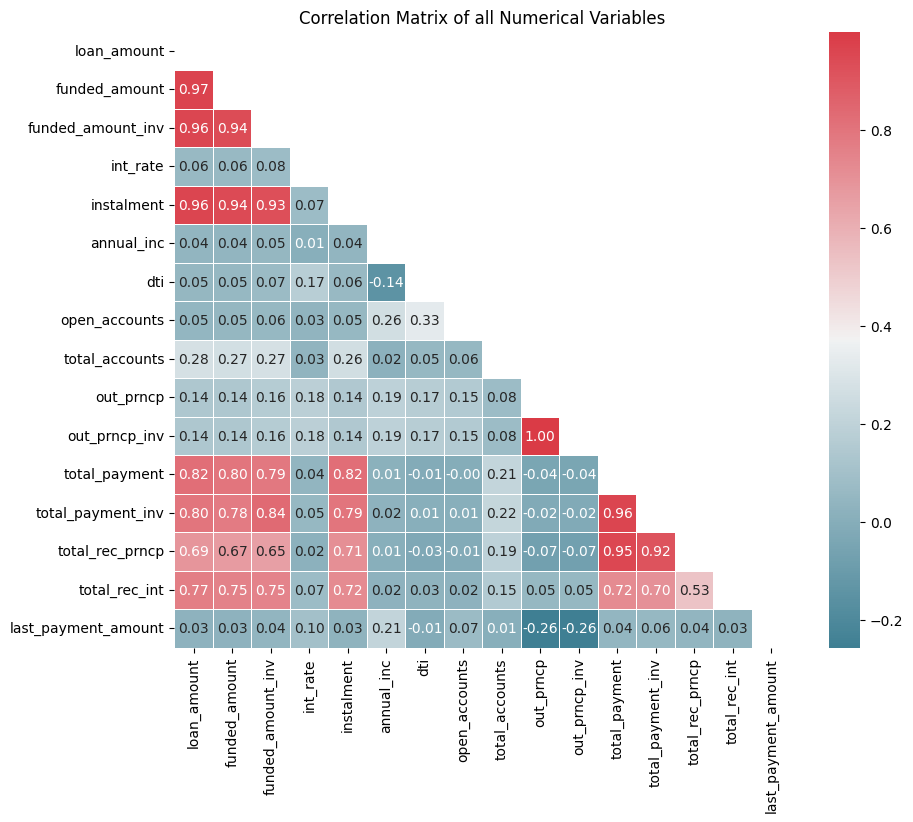

In [342]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)
# matrix.head()

I am going to remove all columns with a correlation greater than .90. In each case I will decide which of the two related columns is best to drop.

In [343]:
df = df_transformer.drop_column(df, df['instalment'])
df = df_transformer.drop_column(df, df['total_payment_inv'])
df = df_transformer.drop_column(df, df['funded_amount'])
df = df_transformer.drop_column(df, df['funded_amount_inv'])
df = df_transformer.drop_column(df, df['total_rec_prncp'])
df = df_transformer.drop_column(df, df['out_prncp_inv'])

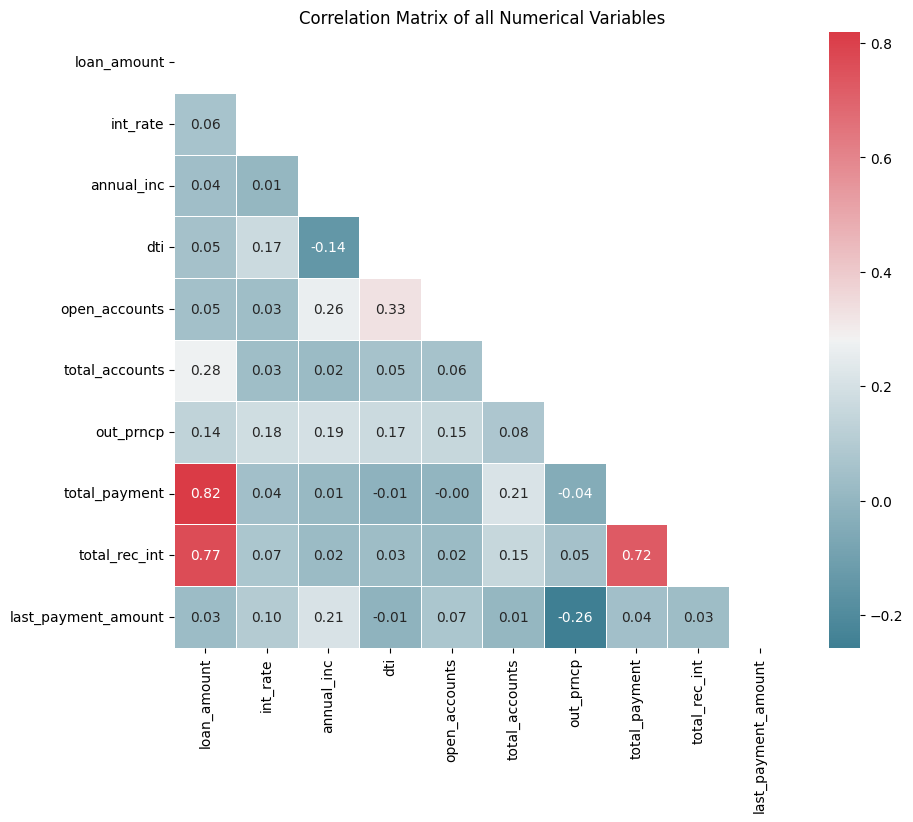

In [344]:
numeric_df = df_info.get_numeric_columns_from_df(df).drop(['id', 'member_id'], axis=1)
matrix = plotter.correlation_matrix(numeric_df)
# matrix.head()

In [345]:
df.head()

,id,member_id,loan_amount,term,int_rate,sub_grade,employment_length,home_ownership,annual_inc,verification_status,...,total_payment,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,application_type
0,38676116,41461848,68.067212,36 months,7.49,A4,5 years,MORTGAGE,10.736397,Not Verified,...,33.080669,10.850112,0,0,0,2022-01-01,248.82,2022-01-01,0.0,INDIVIDUAL
1,38656203,41440010,82.085127,36 months,6.99,A3,9 years,RENT,10.819778,Not Verified,...,38.855134,12.088465,0,0,0,2022-01-01,407.52,2022-01-01,0.0,INDIVIDUAL
2,38656154,41439961,88.179753,36 months,7.49,A4,8 years,MORTGAGE,11.210644,Source Verified,...,57.674729,12.224171,0,0,0,2021-10-01,12850.16,2021-10-01,0.0,INDIVIDUAL
3,38656128,41439934,86.087783,36 months,14.31,C4,1 year,RENT,10.645425,Source Verified,...,56.708290,12.645854,0,0,0,2021-06-01,13899.67,2021-06-01,0.0,INDIVIDUAL
4,38656121,41439927,86.087783,36 months,6.03,A1,10+ years,MORTGAGE,11.884489,Verified,...,40.310795,12.023592,0,0,0,2022-01-01,456.54,2022-01-01,0.0,INDIVIDUAL


Threshold is 0.93